In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True
from scipy import stats

import pastas as ps
ps.show_versions()

import logging, sys
logging.disable(sys.maxsize)

/Applications/anaconda3/envs/mude/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Pastas version: 1.9.0
Python version: 3.11.4
NumPy version: 1.24.3
Pandas version: 2.2.2
SciPy version: 1.10.1
Matplotlib version: 3.7.1
Numba version: 0.57.0


Definition of the extremes of calibration and validation periods according to the Groundwater Challenge instructions.  
- Calibration period: data used to fit the model.  
- Validation period: data used to test the model's predictive performance.

In [2]:
tmin_cal = "2001-01-01"
tmax_cal = "2015-12-31"
tmin_val = "2016-01-01"
tmax_val = "2021-12-31"

Importing the data.  
- `head`: Time series data of observed groundwater head levels, loaded from a CSV file.
- `stresses`: Time series data of various stressors, loaded from a CSV file.
Data is indexed by dates for time series analysis.  
This specific stresses dataset includes: 
- Precipitation data stored in the `prec` variable in [mm/day].
- Evaporation data stored in the `evap` variable in [mm/day].  
- Temperature data stored in the `temp` variable in [°C].\
Two different head datasets are provided, they are both imported, nonetheless, they are the exact same and cover the totality of the avaiable head observations.  
Using the complete head observations dataset, two subsets are created, one covering the calibration period (`head_cal`) and one covering the validation period (`head_val`).

In [3]:
head = pd.read_csv("data/heads.csv", index_col=0, parse_dates=True).squeeze()
head_full = pd.read_csv("data/heads_full.csv", index_col=0, 
                       parse_dates=True).squeeze()

stresses = pd.read_csv("data/input_data.csv", index_col=0, parse_dates=True).squeeze()
prec = stresses.iloc[:, 0].rename("prec").dropna()
evap = stresses.iloc[:, 8].rename("evap").dropna()
temp = stresses.iloc[:, 1].rename("temp").dropna()

In [4]:
head_cal = head[(head.index >= tmin_cal) & (head.index <= tmax_cal)]
head_val = head_full[(head_full.index >= tmin_val) & (head_full.index <= tmax_val)]

This plot provides a summary of the observed groundwater head levels and stressors over time.  
The visualization helps identify trends and patterns before model fitting, as well as getting a first idea of the order of magnitude of the head levels and stressors.

*The head values are not appearing in the plot*

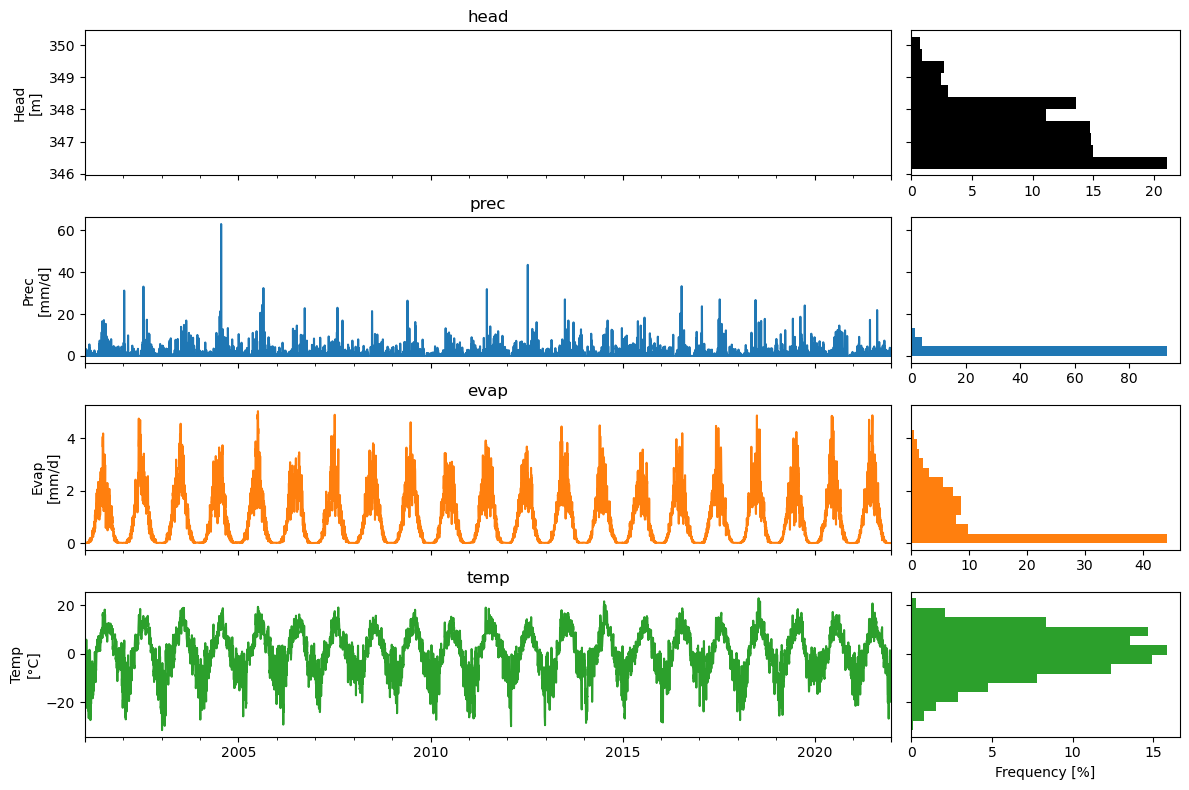

In [31]:
axes = ps.plots.series(
        head=head,
        stresses=[prec, evap, temp],
        tmin = tmin_cal,
        tmax = tmax_val,
        labels=["Head\n[m]", "Prec\n[mm/d]", "Evap\n[mm/d]", "Temp\n[°C]"],
        figsize = (12, 8))

Validation of imported datasets. This is done to make sure they meet the requirements to be used in PASTAS models.

In [6]:
ps.validate_oseries(head)
ps.validate_stress(prec)
ps.validate_stress(evap)
ps.validate_stress(temp)

True

A non linear FlexModel recharge model is built with an Exponential response function. The option to model for the presence of snow is turned on.

Use of isinstance() detected. This is an experimental feature.

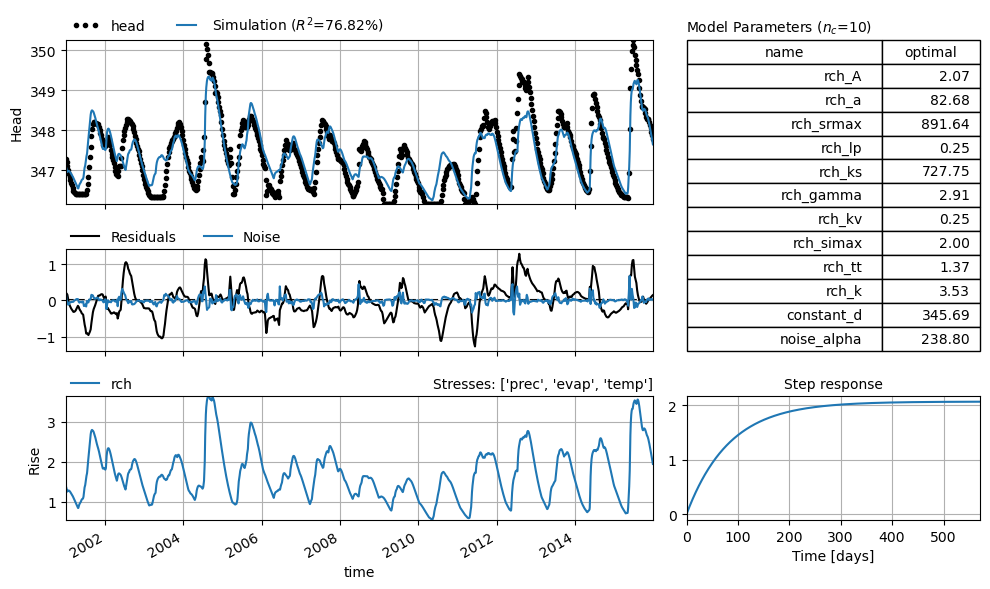

In [7]:
ml = ps.Model(head)

func = ps.Exponential()
rch = ps.rch.FlexModel(snow = True)
sm = ps.RechargeModel(
    prec, 
    evap,
    rfunc=func, 
    recharge = rch,
    name = "rch",
    temp = temp,
)

ml.add_stressmodel(sm)

ml.add_noisemodel(ps.ArNoiseModel())

ml.solve(report=False, tmin=tmin_cal, tmax=tmax_cal, fit_constant = True)


axes = ml.plots.results(figsize=(10, 6))

The head are simulated over the total period including the calibration and validation phases.

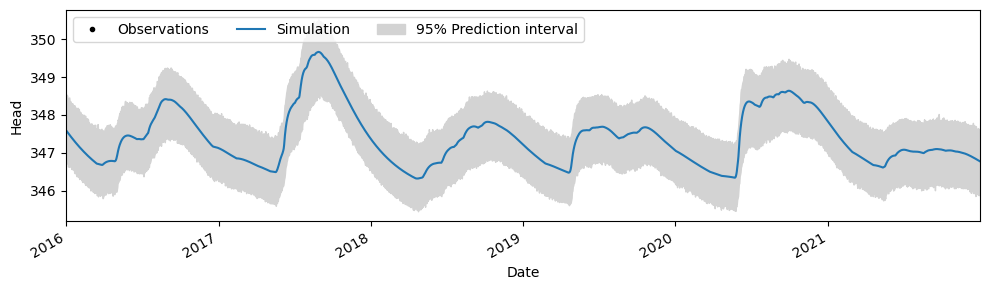

In [8]:
sim_cal = ml.simulate(tmin = tmin_cal, tmax = tmax_cal)
sim_val = ml.simulate(tmin = tmin_val, tmax = tmax_val) 
heads_sim = ml.simulate(tmin = tmin_cal, tmax = tmax_val)

ci_val = ml.solver.prediction_interval(n=1000, alpha = 0.05, max_iter = 10000, tmin = tmin_val, tmax = tmax_val)
ci_cal = ml.solver.prediction_interval(n=1000, alpha = 0.05, max_iter = 10000, tmin = tmin_cal, tmax = tmax_cal)
ci_tot = ml.solver.prediction_interval(n=1000, alpha = 0.05, max_iter = 10000, tmin = tmin_cal, tmax = tmax_val)
ax = ml.plot(figsize=(10, 3), tmin = tmin_val, tmax = tmax_val)
ax.fill_between(ci_val.index, ci_val.iloc[:, 0], ci_val.iloc[:, 1], color="lightgray")
ax.legend(["Observations", "Simulation", "95% Prediction interval"], ncol=3, loc=2)

A comprehensive plot is provided including:
- scatter plot of observed head values over the total period (2001 - 2016).
- simulated head over the total period (2001 - 2021).
- 95% prediction interval over the validation period (2016 - 2021).

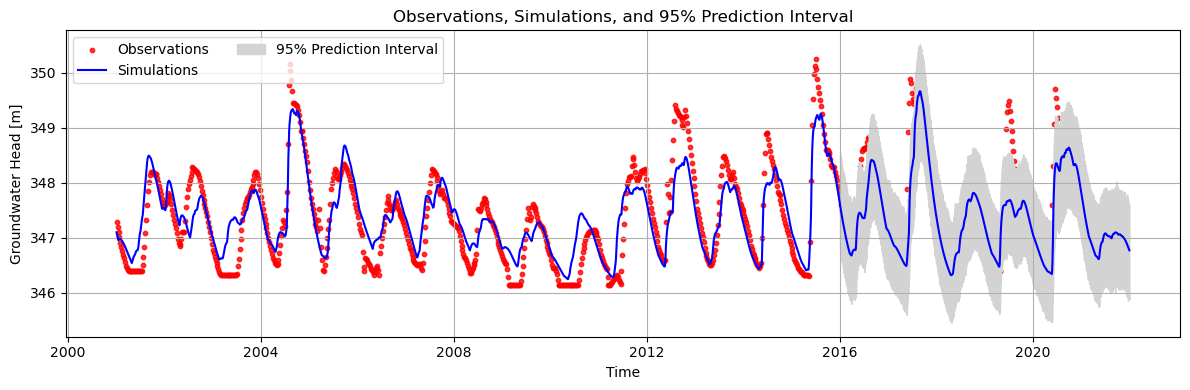

In [9]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.scatter(
    head_full.index,
    head_full,
    label="Observations",
    color="red",
    s=10,
    alpha=0.8,
)


ax.plot(
    heads_sim.index,
    heads_sim,
    label="Simulations",
    color="blue",
    linewidth=1.5,
)


ax.fill_between(
    ci_val.index,
    ci_val.iloc[:, 0],
    ci_val.iloc[:, 1],
    color="lightgray",
    label="95% Prediction Interval",
)


ax.set_title("Observations, Simulations, and 95% Prediction Interval")
ax.set_xlabel("Time")
ax.set_ylabel("Groundwater Head [m]")
ax.legend(loc="upper left", ncol=2)
ax.grid()

plt.show()

**Diagnostics checking**

A diagnostics check is performed. This is done to ensure that the model adequately describes the observed time series.

The check is conducted to test the assumptions for white noise:
- No significant autocorrelation;
- Residuals are homoscedastic;
- Residuals follow a normal distribution.

The results of the diagnostics check show that all tests reject the null hypothesis, meaning that the data do not agree with the assumptions.

In [10]:
ml.stats.diagnostics(alpha=0.05)

,Checks,Statistic,P-value,Reject H0 ($\alpha$=0.05)
Shapiroo,Normality,0.90,0.00,True
D'Agostino,Normality,203.85,0.00,True
Runs test,Autocorr.,-15.41,0.00,True
Ljung-Box,Autocorr.,9.29,0.00,True
Durbin-Watson,Autocorr.,0.84,nan,False


**Reducing autocorrelation**

Autocorrelation is computed and displayed for time lags from 1 to 365 days. The autocorrelation plot shows that autocorrelation gradually decreases reaching minimum values around a lag of 11-12 days.

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

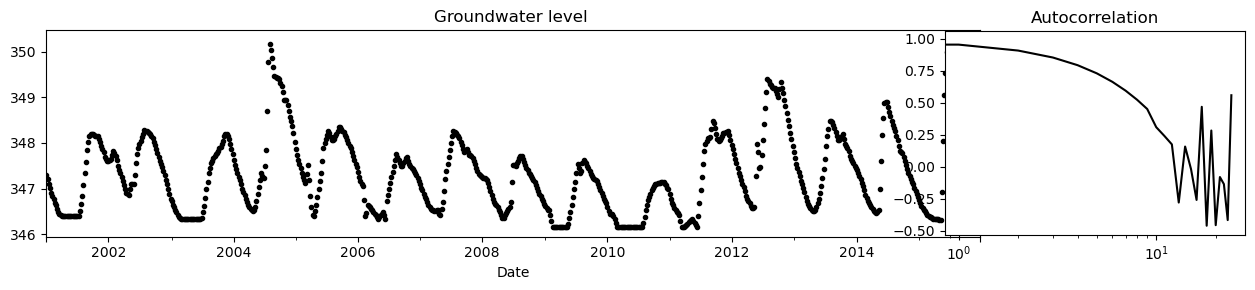

In [11]:
ax = head.plot(figsize=(10, 3), marker=".", linestyle=" ", color="k")
ax1 = plt.axes([0.95, 0.2, 0.3, 0.68])
acf = ps.stats.acf(
    head,
    lags=[
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        12,
        13,
        14,
        30,
        61,
        90,
        120,
        150,
        180,
        210,
        240,
        270,
        300,
        330,
        365,
    ],
).values
ax1.semilogx(acf, color="k") 
ax.set_title("Groundwater level ")
ax1.set_title("Autocorrelation");

In [12]:
#From above I see autocorrelation dropping after 10 days lag, I simulate three models with 7, 14, 21 ùdays lag
mls_ar = {}
dts = 4

func = ps.Exponential()
rch = ps.rch.FlexModel(snow = True)

for dt in range(1, dts, 1):
    ml_name = f"SW_{dt}"
    ml = ps.Model(head.iloc[::dt], name=ml_name)
    ml.add_noisemodel(ps.ArNoiseModel())


    sm = ps.RechargeModel(
    prec, 
    evap,
    rfunc=func, 
    recharge = rch,
    name = "rch",
    temp = temp,
    )
    ml.add_stressmodel(sm)


    ml.solve(report=False, tmin=tmin_cal, tmax=tmax_cal, fit_constant = True)
    mls_ar[ml_name] = ml

The previously created groundwater models (`mls_ar`) are modyfied to analyze the impact of changing the noise model from autoregressive (AR) to autoregressive-moving-average (ARMA). The modified models are then calibrated and stored for comparison.

Outputs:
- Recalibrated models stored in `mls_arma`.
- Each model is identical to the one in `mls_ar`, except for the noise model type (ARMA instead of AR).

--> a decision can be made about the type of noise model to use.

In [13]:
mls_arma = {}

for ml_name, ml in mls_ar.items():
    ml = ml.copy(name=ml.name)

    ml.del_noisemodel()
    ml.add_noisemodel(ps.ArmaNoiseModel())

    ml.solve(tmin=tmin_cal, tmax=tmax_cal, report=False)
    mls_arma[ml_name] = ml

The results of the simulations are shown below. Two different noisemodels are applied, the models are calibrated with an increasing timestep between observations. A Stoffer-Toloi test for autocorrelation is applied on the models with different noisemodels and time lags between observations.

In this case, a model with an ARMA(1,1) noisemodel, with a 21 days time lag shows the lowest autocorrelation.

In [14]:
alpha = 0.05
for ml in mls_ar.values():
    if "SW" in ml.name:
        name, i = ml.name.split("_")
        n = ml.noise(tmin=tmin_cal, tmax=tmax_val).asfreq(f"{i}D").fillna(0.0)
        stat, p = ps.stats.stoffer_toloi(n)
        if p > alpha:
            print(f"AR noisemodel, {name, i}: Failed to reject the Null-hypothesis, no significant autocorrelation. p =",p.round(2))
        else:
            print(f"AR noisemodel, {name, i}:Reject the Null-hypothesis")
        

for ml in mls_arma.values():
    if "SW" in ml.name:
        name, i = ml.name.split("_")
        n = ml.noise(tmin=tmin_cal, tmax=tmax_val).asfreq(f"{i}D").fillna(0.0)
        stat, p = ps.stats.stoffer_toloi(n)
        if p > alpha:
            print(f"ARMA noisemodel, {name, i}: Failed to reject the Null-hypothesis, no significant autocorrelation. p =",p.round(2))
        else:
            print(f"ARMA noisemodel, {name, i}:Reject the Null-hypothesis")

AR noisemodel, ('SW', '1'):Reject the Null-hypothesis
AR noisemodel, ('SW', '2'):Reject the Null-hypothesis
AR noisemodel, ('SW', '3'):Reject the Null-hypothesis
ARMA noisemodel, ('SW', '1'):Reject the Null-hypothesis
ARMA noisemodel, ('SW', '2'):Reject the Null-hypothesis
ARMA noisemodel, ('SW', '3'): Failed to reject the Null-hypothesis, no significant autocorrelation. p = 0.11


Now check the influence of the starting date

In [15]:
mls_with = {}
dt = 3


func = ps.Exponential()
rch = ps.rch.FlexModel(snow = True)

for start in range(0, dt, 1):
    ml_name = f"SW_{start + 1}"
    ml = ps.Model(head.iloc[start::dt], name=ml_name)

    sm = ps.RechargeModel(
    prec, 
    evap,
    rfunc=func, 
    recharge = rch,
    name = "rch",
    temp = temp,
    )
    ml.add_stressmodel(sm)

    
    ml.add_noisemodel(ps.ArmaNoiseModel())
    ml.solve(tmin=tmin_cal, tmax=tmax_cal, report=False)

    mls_with[ml_name] = ml

In [16]:
mls_without = {}
dt = 3


func = ps.Exponential()
rch = ps.rch.FlexModel(snow = True)

for start in range(0, dt, 1):
    ml_name = f"SW_{start + 1}"
    ml = ps.Model(head.iloc[start::dt], name=ml_name)


    sm = ps.RechargeModel(
    prec, 
    evap,
    rfunc=func, 
    recharge = rch,
    name = "rch",
    temp = temp,
    )
    ml.add_stressmodel(sm)

    ml.solve(tmin=tmin_cal, tmax=tmax_cal, report=False)

    mls_without[ml_name] = ml

In [17]:
data = {}

name = "SW"
ml = mls_with["{}_1".format(name)]
p = ml.parameters
mi = pd.MultiIndex.from_product([p.index[p.vary].to_list(), ["opt", "std"]])
data[name] = pd.DataFrame(data=np.nan, index=range(dt, 1), columns=mi, dtype=float)

for ml in mls_with.values():
    if "SW" in ml.name:
        name, i = ml.name.split("_")
        df = data[name]
        for par in ml.parameters.index[ml.parameters.vary]:
            df.loc[int(i), (par, "opt")] = ml.parameters.loc[par, "optimal"]
            df.loc[int(i), (par, "std")] = ml.parameters.loc[par, "stderr"]


df_with = pd.concat(data, axis=1)

In [18]:
data = {}

name = "SW"
ml = mls_without["{}_1".format(name)]
p = ml.parameters
mi = pd.MultiIndex.from_product([p.index[p.vary].to_list(), ["opt", "std"]])
data[name] = pd.DataFrame(data=np.nan, index=range(dt, 1), columns=mi, dtype=float)

for ml in mls_without.values():
    if "SW" in ml.name:
        name, i = ml.name.split("_")
        df = data[name]
        for par in ml.parameters.index[ml.parameters.vary]:
            df.loc[int(i), (par, "opt")] = ml.parameters.loc[par, "optimal"]
            df.loc[int(i), (par, "std")] = ml.parameters.loc[par, "stderr"]

df_without = pd.concat(data, axis=1)

### Parameter Variability Across Models

This code plots error bars to compare parameter variability across models with and without a noise model.

- Extracts models & parameters from `df_with`.
- Creates subplots for each parameter.
- Loops through parameters, checking for `opt` (optimized values) and `std` (standard deviation).
- Plots error bars for both datasets (`df_with` and `df_without`), showing uncertainty.
- Formats plots with labels, legends, grid lines, and a shared x-axis.
- Skips missing parameters and prints a message.

The result visualizes how the noise model affects different parameters as well as the influence of starting the simulation from different timesteps.

Skipping noise_alpha, columns not found in df.
Skipping noise_beta, columns not found in df.


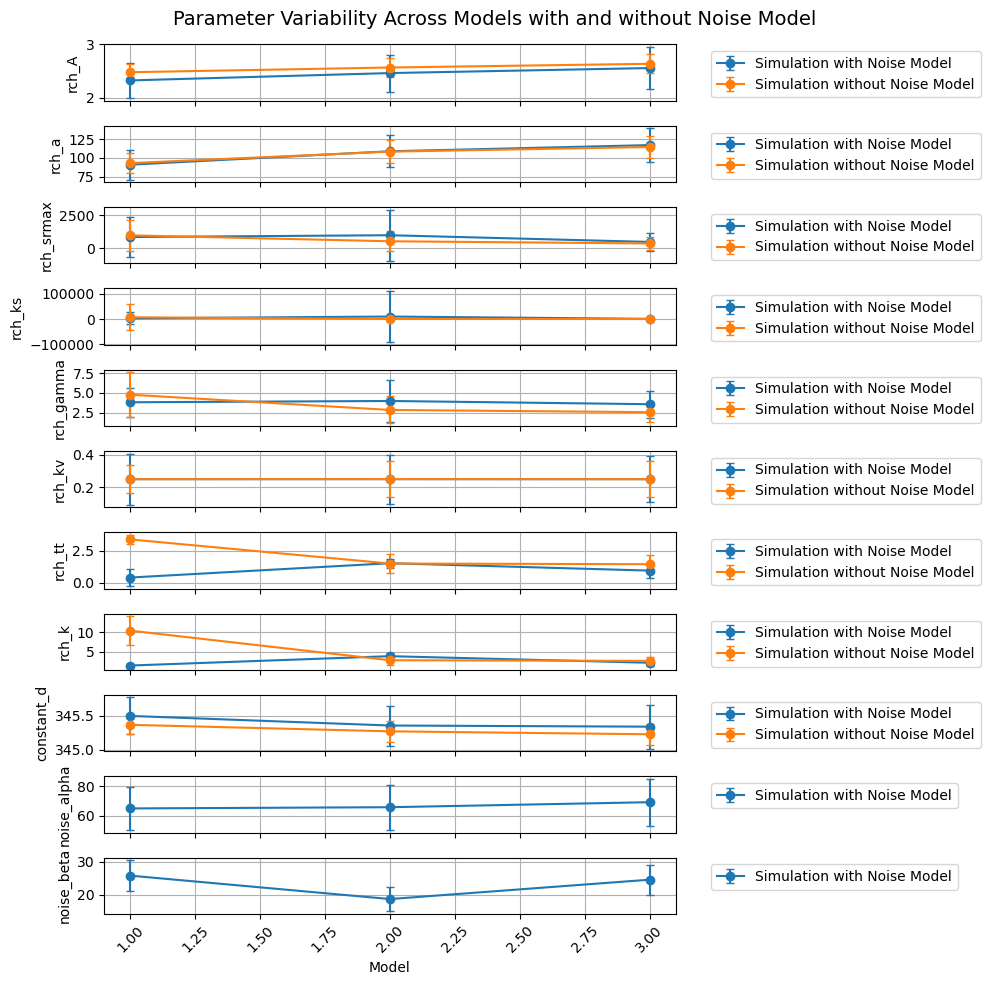

In [19]:
models = df_with.index
std_avg_with = []
std_avg_without = []
parameters = df_with["SW"].columns.get_level_values(0).unique()

fig, axes = plt.subplots(len(parameters), 1, figsize=(10, 10), sharex=True)

for i, param in enumerate(parameters):
    if ("SW", param, "opt") in df_with.columns and ("SW", param, "std") in df_with.columns:
        opt_with = df_with[("SW", param, "opt")]
        std_with = df_with[("SW", param, "std")]
        std_avg_with.append(std_with.mean())

        axes[i].errorbar(df_with.index, opt_with, yerr=std_with, fmt="-o", capsize=3, label = "Simulation with Noise Model")
        axes[i].set_ylabel(param)
        axes[i].grid(True)
        axes[i].legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=10, frameon=True)
    else:
        print(f"Skipping {param}, columns not found in df.")
        
    if ("SW", param, "opt") in df_without.columns and ("SW", param, "std") in df_without.columns:
        opt_without = df_without[("SW", param, "opt")]
        std_without = df_without[("SW", param, "std")]
        std_avg_without.append(std_with.mean())

        axes[i].errorbar(df_without.index, opt_without, yerr=std_without, fmt="-o", capsize=3, label = "Simulation without Noise Model")
        axes[i].set_ylabel(param)
        axes[i].grid(True)
        axes[i].legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=10, frameon=True)
    else:
        print(f"Skipping {param}, columns not found in df.")

axes[-1].set_xlabel("Model")
fig.suptitle("Parameter Variability Across Models with and without Noise Model", fontsize=14)


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The uncertainty behind the parameters is quantified by computing the standard deviation for both models with and without the noisemodel. Please note that the plot displays normalized values of the parameters.

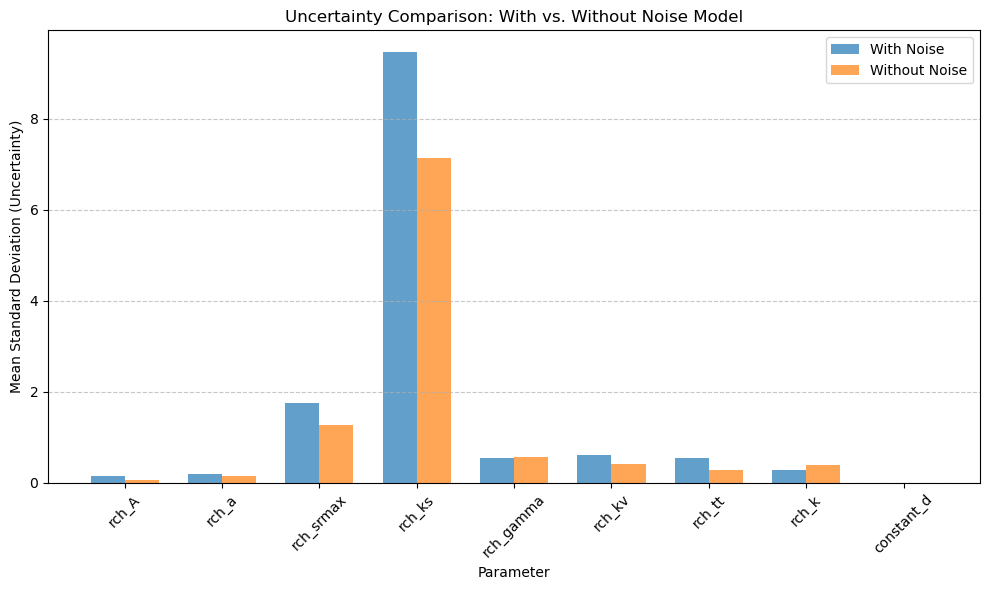

In [20]:
std_avg_with = [df_with[("SW", param, "std")].mean() / df_with[("SW", param, "opt")].mean()for param in parameters[:-2]]
std_avg_without = [df_without[("SW", param, "std")].mean() / df_without[("SW", param, "opt")].mean()for param in parameters[:-2]]


uncertainty_df = pd.DataFrame({
    "Parameter": parameters[:-2],
    "With Noise": std_avg_with,
    "Without Noise": std_avg_without
})


fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(parameters[:-2]))

bars1 = ax.bar(index, std_avg_with, bar_width, label='With Noise', alpha=0.7)
bars2 = ax.bar(index + bar_width, std_avg_without, bar_width, label='Without Noise', alpha=0.7)

ax.set_xlabel('Parameter')
ax.set_ylabel('Mean Standard Deviation (Uncertainty)')
ax.set_title('Uncertainty Comparison: With vs. Without Noise Model')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(parameters[:-2], rotation=45)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()
plt.show()

The diagnostics check is conducted again and the autocorrelation problem seems to be resolved for model 3 with noisemodel ARMA(1,1) and a time lag of 21 days regardless of the starting date of the simulation.

In [21]:
for name, model in mls_with.items():
    noise = model.noise()
    print(f"Model name: {name}, Noisemodel: ARMA(1,1) ")
    stat, p = ps.stats.stoffer_toloi(noise)
    alpha = 0.05

    if p > alpha:
        print(
            "Failed to reject the Null-hypothesis, no significant autocorrelation. p =",
            p.round(2),
        )
    else:
        print("Reject the Null-hypothesis")

Model name: SW_1, Noisemodel: ARMA(1,1) 
Failed to reject the Null-hypothesis, no significant autocorrelation. p = 0.58
Model name: SW_2, Noisemodel: ARMA(1,1) 
Failed to reject the Null-hypothesis, no significant autocorrelation. p = 0.45
Model name: SW_3, Noisemodel: ARMA(1,1) 
Failed to reject the Null-hypothesis, no significant autocorrelation. p = 0.35


In [22]:
model_with = mls_with["SW_3"]
model_without = mls_without["SW_3"]

Autocorrelation is visually inspected and a stoffer-toloi check is computed, both showing positive results, there is no significant autocorrelation.

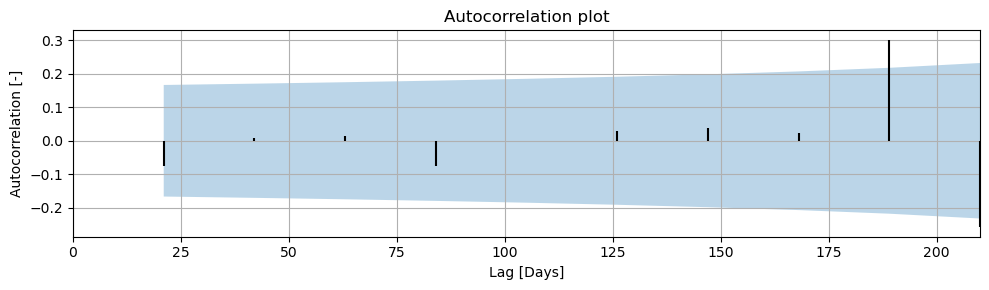

In [23]:
noise = model_with.noise()
ax = ps.plots.acf(noise, acf_options=dict(bin_width=0.5), figsize=(10, 3), alpha=0.01)

**Normality Checking**

Normality is checked visually by looking at the probability plot and at the histogram of the residuals with a normal distribution fit to it.

There is no perfect fit between the line of perfect normality and the points on the probability plot, the trend is nonetheless followed and the points align better in the lower tail.
Normality cannot be confirmed, as the null-hypothesis of the normality check is rejected.

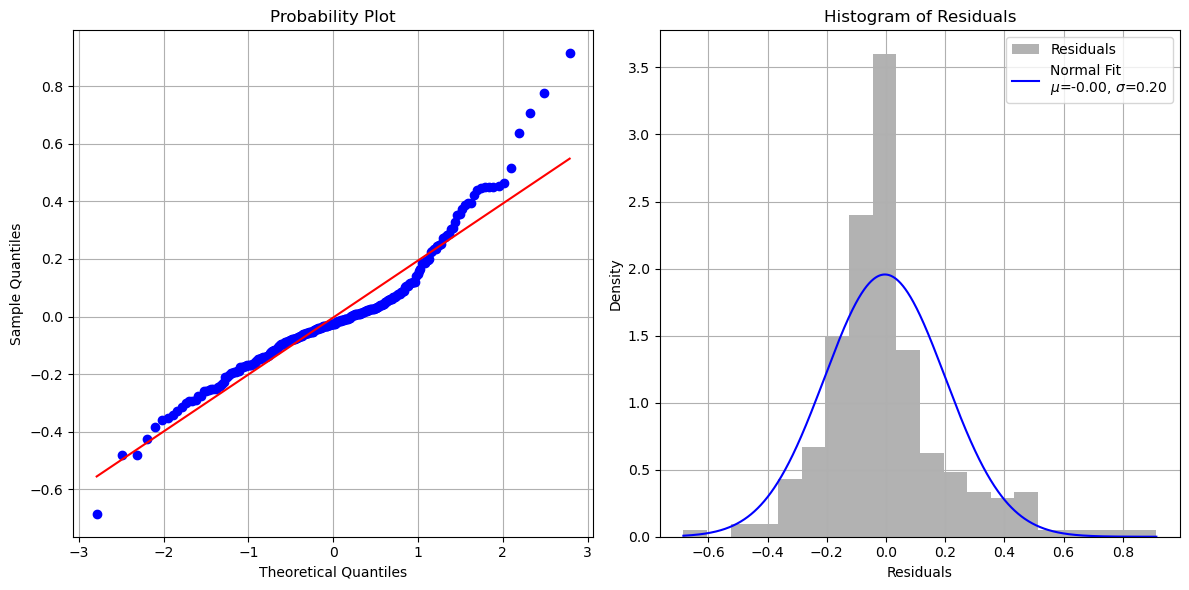

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))


stats.probplot(noise, dist="norm", plot=axes[0])
axes[0].set_title("Probability Plot")
axes[0].set_xlabel("Theoretical Quantiles")
axes[0].set_ylabel("Sample Quantiles")
axes[0].grid()

axes[1].hist(noise, bins=20, density=True, alpha=0.6, color="gray", label="Residuals")


mu, std = stats.norm.fit(noise)
x = np.linspace(min(noise), max(noise), 1000)
pdf = stats.norm.pdf(x, loc=mu, scale=std)
axes[1].plot(x, pdf, color="blue", label=f"Normal Fit\n$\mu$={mu:.2f}, $\sigma$={std:.2f}")
axes[1].set_title("Histogram of Residuals")
axes[1].set_xlabel("Residuals")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

In [25]:
stat, p = stats.normaltest(noise)

if p > 0.5:
    print(
        "Failed to reject the Null-hypothesis, residuals may come from Normal distribution. p =",
        p.round(2),
    )
else:
    print("Reject the Null-hypothesis. p =", p.round(2))

Reject the Null-hypothesis. p = 0.0


**Homoscedasticity Checking**

Homoscedasticity is visually inspected, the goal is to check wheter values of the residuals are independent of the observed groundwater levels.

The spread of residuals seems consistent across the range of simulated groundwater levels, with no clear pattern of increasing or decreasing variance. The residuals appear randomly distributed around zero, without any systematic trend or curvature. 
These observations suggests that the assumption of homoscedasticity might be valid.

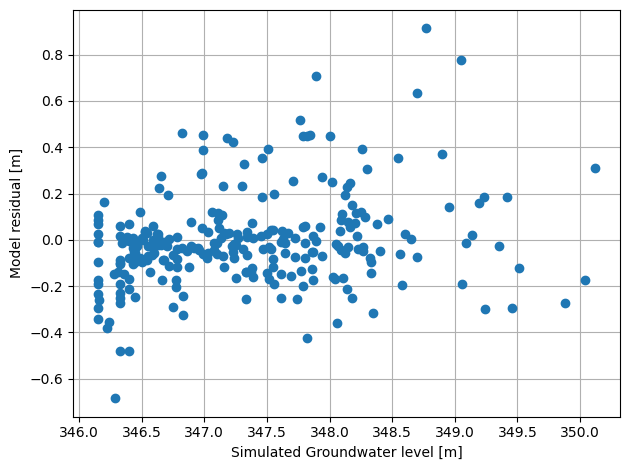

In [26]:
plt.plot(model.observations(), model.noise(), marker="o", linestyle=" ")
plt.xlabel("Simulated Groundwater level [m]")
plt.ylabel("Model residual [m]")
plt.grid()

**Performance Assessment**

After the diagnostics checking and the reduction of autocorrelation the performance of the model is assessed using two different metrics, as requested from the groundwater challenge.  
The metrics applied are:
- Nash-Sutcliffe Efficiency (NSE) over the two periods;
- Mean Absolute Error (MAE) over heads value below the 0.2 quantile and above the 0.8 quantile for both calibration and validation periods.  

The results show better fit in the calibration period, with better representation of high end values.

In [27]:
sim_cal_with = model_with.simulate(tmin = tmin_cal, tmax = tmax_cal)
sim_val_with = model_with.simulate(tmin = tmin_val, tmax = tmax_val)
heads_sim_with = model_with.simulate(tmin = tmin_cal, tmax = tmax_val)

nse_cal_with = ps.stats.metrics.nse(obs = head_cal, sim = sim_cal_with)
nse_val_with = ps.stats.metrics.nse(obs = head_val, sim = sim_val_with)

q02_obs_cal_with = head_cal[head_cal <= head_cal.quantile(0.2)]
q02_sim_cal_with = sim_cal_with.loc[q02_obs_cal_with.index]

q02_obs_val_with = head_val[head_val <= head_val.quantile(0.2)]
q02_sim_val_with = sim_val_with.loc[q02_obs_val_with.index]

q08_obs_cal_with = head_cal[head_cal <= head_cal.quantile(0.8)]
q08_sim_cal_with = sim_cal_with.loc[q08_obs_cal_with.index]

q08_obs_val_with = head_val[head_val <= head_val.quantile(0.8)]
q08_sim_val_with = sim_val_with.loc[q08_obs_val_with.index]

mae_cal02_with = ps.stats.metrics.mae(obs = q02_obs_cal_with, sim = q02_sim_cal_with)
mae_cal08_with = ps.stats.metrics.mae(obs = q08_obs_cal_with, sim = q08_sim_cal_with)

mae_val02_with = ps.stats.metrics.mae(obs = q02_obs_val_with, sim = q02_sim_val_with)
mae_val08_with = ps.stats.metrics.mae(obs = q08_obs_val_with, sim = q08_sim_val_with)


print(f"Results of fit test for model with noisemodel:\n"
      f"  - NSE over calibration period: {nse_cal_with:.4f}.\n"
      f"  - MAE_02 over calibration period: {mae_cal02_with:.4f}.\n"
      f"  - MAE_08 over calibration period: {mae_cal08_with:.4f}.\n"
      "\n"
      f"  - NSE over validation period: {nse_val_with:.4f}.\n"
      f"  - MAE_02 over validation period: {mae_val02_with:.4f}.\n"
      f"  - MAE_08 over validation period: {mae_val08_with:.4f}.\n")

Results of fit test for model with noisemodel:
  - NSE over calibration period: 0.7737.
  - MAE_02 over calibration period: 0.3651.
  - MAE_08 over calibration period: 0.2753.

  - NSE over validation period: 0.6420.
  - MAE_02 over validation period: 0.1658.
  - MAE_08 over validation period: 0.1950.



In [28]:
sim_cal_without = model_without.simulate(tmin = tmin_cal, tmax = tmax_cal)
sim_val_without = model_without.simulate(tmin = tmin_val, tmax = tmax_val)
heads_sim_without = model_without.simulate(tmin = tmin_cal, tmax = tmax_val)

nse_cal_without = ps.stats.metrics.nse(obs = head_cal, sim = sim_cal_without)
nse_val_without = ps.stats.metrics.nse(obs = head_val, sim = sim_val_without)

q02_obs_cal_without = head_cal[head_cal <= head_cal.quantile(0.2)]
q02_sim_cal_without = sim_cal_without.loc[q02_obs_cal_without.index]

q02_obs_val_without = head_val[head_val <= head_val.quantile(0.2)]
q02_sim_val_without = sim_val_without.loc[q02_obs_val_without.index]

q08_obs_cal_without = head_cal[head_cal <= head_cal.quantile(0.8)]
q08_sim_cal_without = sim_cal_without.loc[q08_obs_cal_without.index]

q08_obs_val_without = head_val[head_val <= head_val.quantile(0.8)]
q08_sim_val_without = sim_val_without.loc[q08_obs_val_without.index]

mae_cal02_without = ps.stats.metrics.mae(obs = q02_obs_cal_without, sim = q02_sim_cal_without)
mae_cal08_without = ps.stats.metrics.mae(obs = q08_obs_cal_without, sim = q08_sim_cal_without)

mae_val02_without = ps.stats.metrics.mae(obs = q02_obs_val_without, sim = q02_sim_val_without)
mae_val08_without = ps.stats.metrics.mae(obs = q08_obs_val_without, sim = q08_sim_val_without)


print(f"Results of fit test for model without noisemodel:\n"
      f"  - NSE over calibration period: {nse_cal_without:.4f}.\n"
      f"  - MAE_02 over calibration period: {mae_cal02_without:.4f}.\n"
      f"  - MAE_08 over calibration period: {mae_cal08_without:.4f}.\n"
      "\n"
      f"  - NSE over validation period: {nse_val_without:.4f}.\n"
      f"  - MAE_02 over validation period: {mae_val02_without:.4f}.\n"
      f"  - MAE_08 over validation period: {mae_val08_without:.4f}.\n")

Results of fit test for model without noisemodel:
  - NSE over calibration period: 0.7914.
  - MAE_02 over calibration period: 0.3395.
  - MAE_08 over calibration period: 0.2792.

  - NSE over validation period: 0.6333.
  - MAE_02 over validation period: 0.2343.
  - MAE_08 over validation period: 0.2539.



Over the calibratiton period the model without noisemodel performs better according to the NSE, the difference is limited to a 2%. Over the validation period, the performances of the two models are very similar. The MAE values result to be lower for the model without noisemodel for the calibration period and lower for the model with noisemodel for the calibration period.

The quality of the 95% prediction interval is tested by computing the Prediction Interval Coverage Probability (PICP) to assess the share of values falling the wanted interval.  
The computed PICP is lower than 95% for the calibration and validation periods showing a slight underestimation of the uncertainty.  

In [29]:
periods = [(ci_cal, head_cal, "Calibration"), (ci_val, head_val, "Validation"), (ci_tot, heads_sim, "Total")]


for period in periods:
    low = period[0].iloc[:, 0].reindex(period[1].index)
    up = period[0].iloc[:, 1].reindex(period[1].index)
    bound = pd.DataFrame({'low': low, 'up': up})
    within = period[1][(period[1] >= low) & (period[1] <= up)]

    PICP = len(within)/len(low)*100
    PICP = ps.stats.picp(period[1], bound) #new pastas feature
    print(f"The computed PICP in the {period[2]} Period is: {PICP:.3f}.")

The computed PICP in the Calibration Period is: 0.936.
The computed PICP in the Validation Period is: 0.870.
The computed PICP in the Total Period is: 1.000.
